
# Introduction MixUp
- Author: [Sajjad Ayoubi](https://github.com/sajjjadayobi)


mixup is a domain-agnostic data augmentation technique proposed in mixup

![](https://s4.uupload.ir/files/mixup_w867.png)


It's implemented with the following formulas:

![](https://s4.uupload.ir/files/mixupformula_tav.png)

the lambda values are sampled from the Beta distribution.

- beta distribution: Very high probability of alpha being close to 0 or 1



MixUp Advantages:
- Mixup is a data-agnostic data augmentation routine.
- network does not get overconfident about the relationship between the features and their labels.
- It makes decision boundaries transit linearly from class to class, providing a smoother estimate of uncertainty.
- It reduces the memorization of corrupt labels
- work just like dropout and it's very comfortable with dropout
- inter-class mixup
  - interpolating only between inputs with equal label did not lead to the performance gains of mixup.

### Generalization

from paper

![](https://s4.uupload.ir/files/mixup_intu_d29b.png)

### Why beta distribution?


so it means there is a very high probability of picking values close to 0 or 1 (in which case the image is almost from 1 category) and then a somewhat constant probability of picking something in the middle (0.33 as likely as 0.5 for instance).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def set_default(figsize=(5, 5), dpi=80):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

set_default()

α ∈ [0.1, 0.4] leads to improved performance, smaller α creates less mixup effect, whereas, for large α, mixup leads to underfitting.

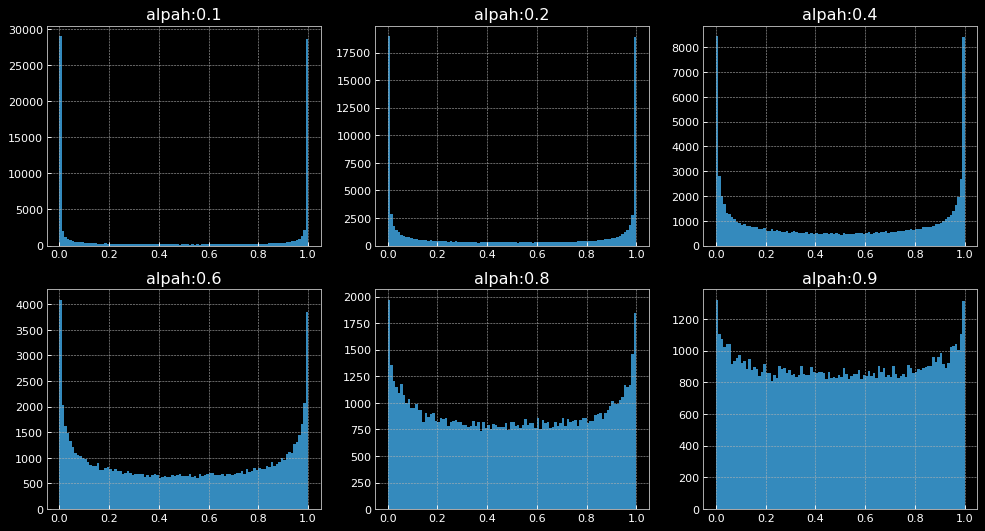

In [ ]:
plt.figure(figsize=(15, 8))
for step, alpha in enumerate([.1, .2, .4, .6, .8, .9]):
    x = np.random.beta(alpha, alpha, size=90000)
    plt.subplot(2, 3, step+1)
    plt.title('alpah:' + str(alpha))
    plt.hist(x, bins=100)

plt.show()

### MNIST example in TF

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(512).batch(64)

# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds_mu = tf.data.Dataset.zip((train_ds, train_ds))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

In [ ]:
def sample_beta_distribution(size, alpha):
    gamma_left = tf.random.gamma(shape=[size], alpha=alpha)
    gamma_right = tf.random.gamma(shape=[size], alpha=alpha)
    beta = gamma_left / (gamma_left + gamma_right)
    return beta


def linear_combination(x1, x2, alpha):
    return x1 * alpha + x2 * (1 - alpha)
    

def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    λ = sample_beta_distribution(batch_size, alpha)
    images_λ = tf.reshape(λ, (batch_size, 1, 1, 1)) # 3channel images
    labels_λ = tf.reshape(λ, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = linear_combination(images_one, images_two, images_λ)
    labels = linear_combination(labels_one, labels_two, labels_λ)

    return (images, labels)

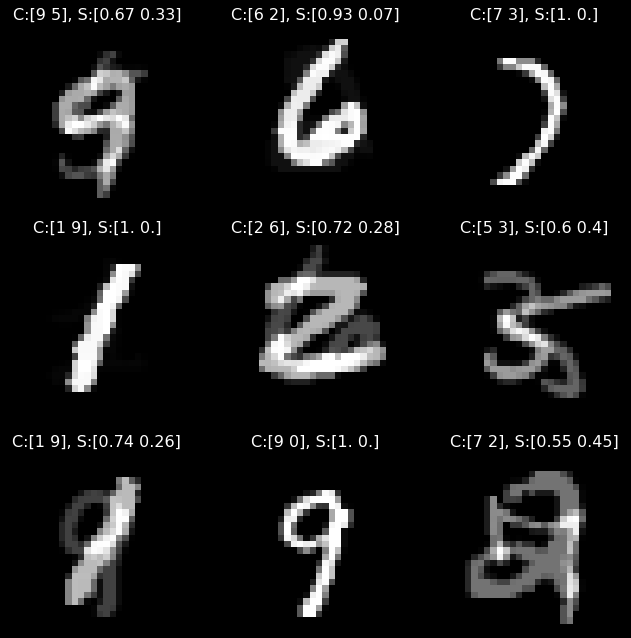

In [ ]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds_mu.map(mix_up, num_parallel_calls=tf.data.AUTOTUNE)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)

    classes = np.argsort(label)[-2:][::-1]
    scores = np.round(label, 2)[classes]
    plt.title(f'C:{classes}, S:{scores}')
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.axis("off")

Note that here , we are combining two images to create a single one. Theoretically, we can combine as many we want but that comes at an increased computation cost. In certain cases, it may not help improve the performance as well.

In [ ]:
def create_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, (3, 3), strides=(2, 2), activation="relu", input_shape=(28, 28, 1)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), activation="relu"),
            layers.Dropout(0.1),
            layers.GlobalAvgPool2D(),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

initial_model = create_model()
initial_model.save_weights("initial_weights.h5")

Train with MixUp
- the difficulty of the task increases, but accuracy improves on the validation set

In [ ]:
model = create_model()
model.load_weights("initial_weights.h5")
optimizer = tf.keras.optimizers.Adam(3e-3)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=test_ds, epochs=10)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 1.6641 - accuracy: 0.4474 - val_loss: 0.6722 - val_accuracy: 0.7952
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.9673 - accuracy: 0.7601 - val_loss: 0.4656 - val_accuracy: 0.8744
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.8436 - accuracy: 0.8121 - val_loss: 0.3837 - val_accuracy: 0.9004
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.7887 - accuracy: 0.8340 - val_loss: 0.3265 - val_accuracy: 0.9164
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.7433 - accuracy: 0.8493 - val_loss: 0.3217 - val_accuracy: 0.9164
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.7220 - accuracy: 0.8562 - val_loss: 0.2797 - val_accuracy: 0.9305
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.6981 - accuracy: 0.8654 - val_loss: 0.2546 - val_accuracy: 0.9361
Epoch 

Train without MixUp

In [ ]:
model = create_model()
model.load_weights("initial_weights.h5")
optimizer = tf.keras.optimizers.Adam(3e-3)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.fit(train_ds, validation_data=test_ds, epochs=10)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 1.4474 - accuracy: 0.4889 - val_loss: 0.5822 - val_accuracy: 0.8124
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.5776 - accuracy: 0.8198 - val_loss: 0.4244 - val_accuracy: 0.8691
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.4434 - accuracy: 0.8617 - val_loss: 0.3288 - val_accuracy: 0.8958
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3871 - accuracy: 0.8806 - val_loss: 0.2940 - val_accuracy: 0.9103
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3410 - accuracy: 0.8940 - val_loss: 0.2491 - val_accuracy: 0.9229
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3080 - accuracy: 0.9032 - val_loss: 0.2175 - val_accuracy: 0.9324
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2875 - accuracy: 0.9118 - val_loss: 0.2255 - val_accuracy: 0.9290
Epoch 

## More
- With mixup, you can create synthetic examples — especially when you lack a large dataset - without incurring high computational costs.
- Label smoothing and mixup usually do not work well together because label smoothing already modifies the hard labels by some factor.
- mixup does not work well when you are using Supervised Contrastive Learning (SCL) since SCL expects the true labels during its pre-training phase.
- A few other benefits of mixup include (as described in the paper) robustness to adversarial examples and stabilized GAN (Generative Adversarial Networks) training.
- I’ve tried it in NLP, mixing the outputs of the embedding layers and it has given good results.
- There are a number of data augmentation techniques that extend mixup such as CutMix and AugMix.